In [1]:
import torch
import transformers
from datasets import load_dataset,load_dataset_builder
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

In [2]:
# I am working on my laptop. No GPU available
device = torch.device("cpu")

In [3]:
# Load the IMDB dataset and understanding the features
dataset = load_dataset("imdb")
ds_builder = load_dataset_builder("imdb")
ds_builder.info.description
ds_builder.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [4]:
# Loading the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/Users/reyessou/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

train_dataset = dataset['train'].map(tokenize, batched=True, batch_size=len(dataset['train']))
test_dataset = dataset['test'].map(tokenize, batched=True, batch_size=len(dataset['test']))

# Format dataset for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [6]:
# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [7]:
# Define evaluation metrics
def compute_metrics(p):
    preds = torch.argmax(torch.from_numpy(p.predictions), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [8]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    eval_strategy="steps",
    eval_steps = 500,                # Evaluate and save every 500 batches 
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=8,   # Batch size (small to fit in memory)
    per_device_eval_batch_size=16,   # Larger batch size for evaluation
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.015,               # Weight decay
    logging_dir="./logs",            # Directory for logs
    logging_steps=10,
    load_best_model_at_end=True,     # Early stopping
    save_total_limit=2,              # Limit the number of checkpoints
    gradient_accumulation_steps=4,
    save_strategy="steps"
)

In [9]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [10]:
# Train the model
trainer.train()
#-------------------------------------
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.181700,0.221635,0.912200,0.879000,0.956000,0.915884
1000,0.182800,0.222309,0.926920,0.924982,0.929200,0.927086
1500,0.078400,0.196851,0.929280,0.932812,0.925200,0.928990
2000,0.092100,0.249238,0.928240,0.944675,0.909760,0.926889


Test Accuracy: 0.9293


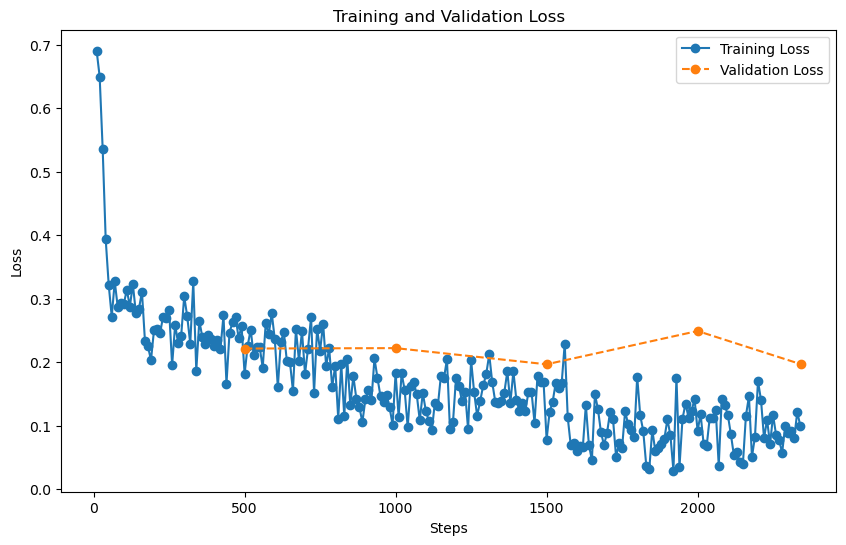

In [30]:
import matplotlib.pyplot as plt

# Extract the loss values from the Trainer logs
log_history = trainer.state.log_history

# Training and validation losses from log history
train_loss = [log['loss'] for log in log_history if 'loss' in log.keys()]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log.keys()]

# Logging steps for training and evaluation from log history
train_steps = [log['step'] for log in log_history if 'loss' in log.keys()]
eval_steps = [log['step'] for log in log_history if 'eval_loss' in log.keys()]

# Plotting the losses as they evolve over training/evaluation
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker='o')
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='o', linestyle='--')

# Label the plot
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Save the plot as a PNG file
plt.savefig("TrainingVsValidationLossVersion1.png")

# Show the plot
plt.show()

In [32]:
trainer.save_model("best_modelVersion1")

In [33]:
# Access the best checkpoint and the corresponding step
best_checkpoint = trainer.state.best_model_checkpoint

# If best_model_checkpoint is not None, extract the step number from the checkpoint path
if best_checkpoint is not None:
    best_step = int(best_checkpoint.split('-')[-1])
    print(f"The best model was found at step {best_step} and saved in '{best_checkpoint}'")
else:
    print("No best model found.")

The best model was found at step 1500 and saved in './results/checkpoint-1500'


In [36]:
#best_step = trainer.state.best_trial
best_metric = trainer.state.best_metric
print(f"The best model was found with a metric value of {best_metric}.")

The best model was found with a metric value of 0.19685108959674835.


In [122]:
# Get the predictions on the validation set
predictions_output = trainer.predict(test_dataset)

# Extract the predictions and true labels
logits = predictions_output.predictions  # Raw output (logits)
true_labels = predictions_output.label_ids  # Ground truth labels

# Convert logits to predicted class labels
pred_labels = np.argmax(logits, axis=1)

In [124]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(cm)

# Print the classification report 
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Confusion Matrix:
[[11667   833]
 [  935 11565]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12500
           1       0.93      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000

